# Collaborative Movie recommendation system

Whether you realize it or not, recommendations drive so many of our decisions on a daily basis. Be it obvious recommendations such as suggestions of new restaurants from friends, or a certain model of camera discussed in a blog, to less direct recommendations such as Netflix promoting shows you are likely to enjoy, or Amazon proposing other purchases that go well with what you are buying. 

There are two popular methods in recommender system, collaborative based filtering and content based filtering. 
- Content based filtering makes predictions of what the audience is likely to prefer based on the content properties, e.g. genre, language, video length. 
- Whereas collaborative filtering predicts based on what other similar users also prefer. 

Lets build Collaborative  recommendation engine using movie database. 
I will be using Movie Database from kaggle (https://www.kaggle.com/code/rounakbanik/movie-recommender-systems/data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings(action='ignore')

# Data Wrangling

In [2]:
movies = pd.read_csv("../data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
df = pd.read_csv("../data/ratings_small.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
df = pd.merge(movies, df).drop(['genres', 'timestamp'], axis=1)

In [5]:
df.shape

(97243, 4)

In [10]:
df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),7,3.0
1,1,Toy Story (1995),9,4.0
2,1,Toy Story (1995),13,5.0
3,1,Toy Story (1995),15,2.0
4,1,Toy Story (1995),19,3.0


Great, We have good amount of data for our analysis.

In [8]:
df.columns

Index(['movieId', 'title', 'userId', 'rating'], dtype='object')

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97243 entries, 0 to 97242
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  97243 non-null  int64  
 1   title    97243 non-null  object 
 2   userId   97243 non-null  int64  
 3   rating   97243 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.7+ MB


Checking basic statistics of each column 

In [197]:
df.describe()

,movieId,userId,rating
count,97243.000000,97243.000000,97243.000000
mean,11889.784190,345.974271,3.549464
std,25496.569681,195.124426,1.054909
min,1.000000,1.000000,0.500000
25%,994.000000,178.000000,3.000000
50%,2353.000000,363.000000,4.000000
75%,5108.000000,518.000000,4.000000
max,161918.000000,671.000000,5.000000


- The minimum rating is 0.5 and max is 5. 
- We have total 671 users.

Check if there are any missing values

In [198]:
df.isnull().sum()

movieId    0
title      0
userId     0
rating     0
dtype: int64

Great we do not have any null value

Lets find how many distinct users and movies are included in the dataset

In [199]:
# Calculate the number of unique values
df.nunique()

movieId    7063
title      7062
userId      671
rating       10
dtype: int64

In [200]:
df.rating.unique()

array([3. , 4. , 5. , 2. , 3.5, 1. , 2.5, 4.5, 1.5, 0.5])

# Exploratory Data Analysis

Lets explore the dataset to find some insights about the data.

<AxesSubplot:>

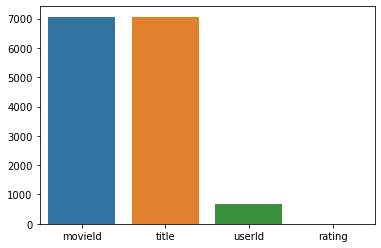

In [201]:
sns.barplot(x = df.columns, y = df.nunique(axis=0))

There are close to 670 users and 7000 movies and 10 unique values of ratings.

Lets perform some univariate analysis.

Univariate analysis — the analysis of one feature at a time.
This will help us fin answers for questions like 
1.	what are the movies with most reviews?
2.	who are the users that provide most reviews?
3.	how does the distribution looks like for ratings?

Calculate the number of times each movie occurs in the dataset.
Print the titles of the top five most frequently seen movies.

In [202]:
# Get the counts of occurrences of each movie title
movie_popularity = df["title"].value_counts()[:5]
## Inspect the most common values
#print(movie_popularity.head().index)

In [203]:
print(movie_popularity)

Forrest Gump (1994)                          341
Pulp Fiction (1994)                          324
Shawshank Redemption, The (1994)             311
Silence of the Lambs, The (1991)             304
Star Wars: Episode IV - A New Hope (1977)    291
Name: title, dtype: int64


Forrest Gump is the most viewed movie by far.

In [204]:
df['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
69118       1
5787        1
68959       1
5788        1
161918      1
Name: movieId, Length: 7063, dtype: int64

<AxesSubplot:>

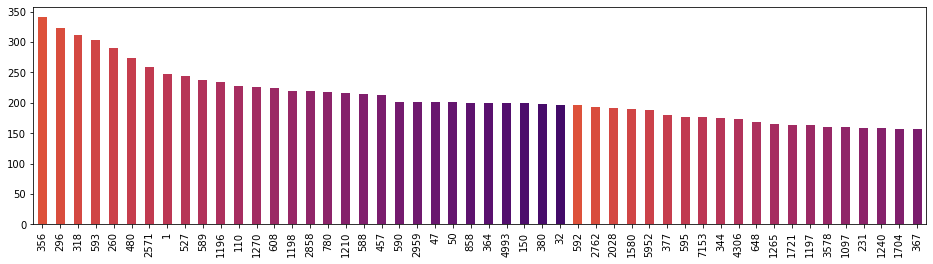

In [205]:
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4, .8, 30))
color

# univariate analysis
plt.figure(1, figsize = (16,4))
df['movieId'].value_counts()[:50].plot(kind = 'bar', stacked=True, color=color) #take top 50 movies


Here we can see that ratings are not evenly distributed among movies.
The movie with id 356[Forrest Gump] is the most rated movie, however it does not have more that 341 ratings.

Lets check userid column.

In [206]:
df['userId'].value_counts()

547    1953
564    1763
624    1734
15     1640
73     1529
       ... 
249      20
498      20
448      20
444      19
485      19
Name: userId, Length: 671, dtype: int64

<AxesSubplot:>

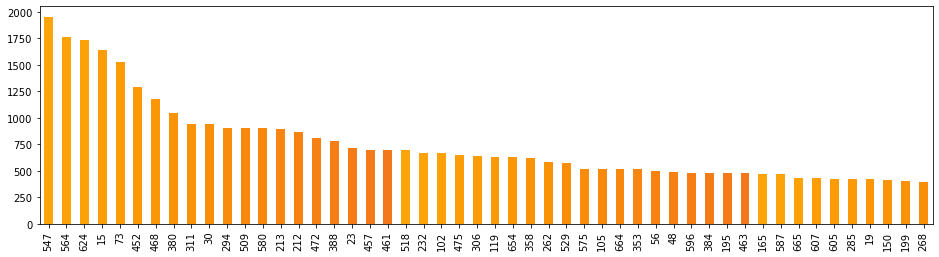

In [207]:
color = cm.inferno_r(np.linspace(.2, .3, 20))
color
plt.figure(2, figsize = (16,4))
df['userId'].value_counts()[:50].plot(kind = 'bar', color=color) #take top 50 users

users have provided 1953 ratings.

Display a histogram of the values in the Rating column

<AxesSubplot:ylabel='Frequency'>

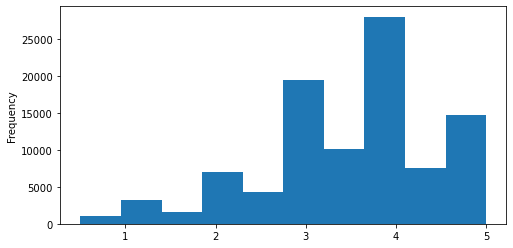

In [208]:
plt.figure(3, figsize = (8,4))
df['rating'].plot(kind = 'hist')

The graph shows, most of the users have given rating of 4.

In [247]:
rating_df = pd.DataFrame(df.groupby('title')['rating'].mean())
rating_df.head()

,rating
title,
'Hellboy': The Seeds of Creation (2004),2.000000
'Round Midnight (1986),2.250000
'Salem's Lot (2004),3.500000
'Til There Was You (1997),2.625000
"'burbs, The (1989)",3.052632


In [250]:
rating_df['number_of_ratings'] = df.groupby('title')['rating'].count()
rating_df.head()

,rating,number_of_ratings
title,,
'Hellboy': The Seeds of Creation (2004),2.000000,1
'Round Midnight (1986),2.250000,2
'Salem's Lot (2004),3.500000,1
'Til There Was You (1997),2.625000,4
"'burbs, The (1989)",3.052632,19


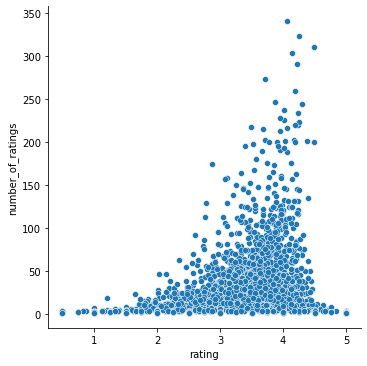

In [251]:
import seaborn as sns
sns.relplot(x="rating", y="number_of_ratings", data=rating_df);

Above plot shows many movies having 0 ratings. Less number of users have rated perticular movies. Most of the users have given rating between 3 to 4.

What is the distribution of ratings given to each movie?

<AxesSubplot:>

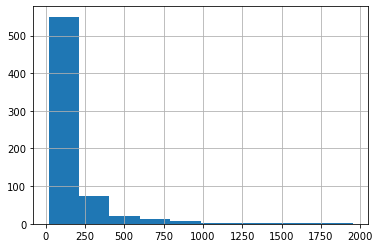

In [252]:
ratings_per_user = df.groupby('userId')['movieId'].count() 
ratings_per_user.hist()

The histogram shows that most users (roughly 560 out of 671 –80%) have less than 250 ratings.

What is the distribution of users who provide ratings?

<AxesSubplot:>

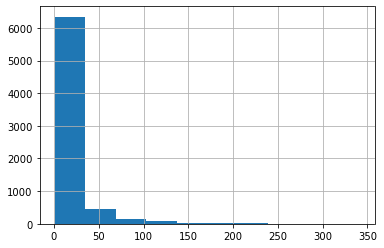

In [253]:
ratings_per_movie = df.groupby('movieId')['userId'].count() 
ratings_per_movie.hist()

The histogram shows that most movies (roughly 6500 out of 7063 –90%) have less than 30 ratings.

### Non-Personalized Suggestions

Just because a movie has been watched by a lot of people doesn't necessarily mean viewers enjoyed it. To understand how a viewer actually felt about a movie, more explicit data is useful. Lets find the average rating of each movie in the dataset, and then find the movie with the highest average rating.

In [254]:
# Find the mean of the ratings given to each title
avg_rating_df = df[["title", "rating"]].groupby('title').mean()

# Order the entries by highest average rating to lowest
sorted_average_ratings = avg_rating_df.sort_values(by='rating', ascending=False)

# Inspect the top movies
print(sorted_average_ratings.head())

                                                    rating
title                                                     
Family Stone, The (2005)                               5.0
Kidnapping, Caucasian Style (Kavkazskaya plenni...     5.0
Female Perversions (1996)                              5.0
Grass Is Greener, The (1960)                           5.0
Ben X (2007)                                           5.0


The highest ranked movie is shown as Family Stone, The (2005). which does not seem to be heard of as popular movie. This seems to be because of very infrequently-viewed movies are skewing the results. 

In [255]:
df[df['title'] == 'Family Stone, The (2005)']

,movieId,title,userId,rating
85903,41573,"Family Stone, The (2005)",382,5.0


As we can see, above movie is highly ranked but only one user has rated this movie.

Let's find the average rating only for movies that have been reviewed more than 50 times.

In [256]:
# Create a list of only the frequently watched movies
movie_popularity = df["title"].value_counts()
print(movie_popularity)
popular_movies = movie_popularity[movie_popularity > 50].index

Forrest Gump (1994)                                                                                                          341
Pulp Fiction (1994)                                                                                                          324
Shawshank Redemption, The (1994)                                                                                             311
Silence of the Lambs, The (1991)                                                                                             304
Star Wars: Episode IV - A New Hope (1977)                                                                                    291
                                                                                                                            ... 
In the Electric Mist (2009)                                                                                                    1
Truth About Charlie, The (2002)                                                                  

In [257]:
# Use this popular_movies list to filter the original DataFrame
popular_movies_rankings = df[df["title"].isin(popular_movies)]

# Inspect the movies watched over 50 times
print(popular_movies_rankings)

       movieId             title  userId  rating
0            1  Toy Story (1995)       7     3.0
1            1  Toy Story (1995)       9     4.0
2            1  Toy Story (1995)      13     5.0
3            1  Toy Story (1995)      15     2.0
4            1  Toy Story (1995)      19     3.0
...        ...               ...     ...     ...
92624    79132  Inception (2010)     628     3.5
92625    79132  Inception (2010)     630     3.5
92626    79132  Inception (2010)     655     2.0
92627    79132  Inception (2010)     660     4.5
92628    79132  Inception (2010)     664     5.0

[42633 rows x 4 columns]


In [258]:
# Find the average rating given to these frequently watched films
popular_movies_average_rankings = popular_movies_rankings[["title", "rating"]].groupby('title').mean()
print(popular_movies_average_rankings.sort_values(by="rating", ascending=False).head())

                                    rating
title                                     
Godfather, The (1972)             4.487500
Shawshank Redemption, The (1994)  4.487138
Maltese Falcon, The (1941)        4.387097
Godfather: Part II, The (1974)    4.385185
Usual Suspects, The (1995)        4.370647


We can now see the non-personalized recommendations that combine both the ratings of an item and how frequently it has been interacted with.

# Collaborative Types of Filtering

## Memory Based Filtering 

Memory-based collaborative filtering uses all the data in the database to generate a prediction

There are two types of Memory Based Collaborative Filtering :

- User-User-based similarity/Collaborative Filtering
- Item-Item-based similarity/Collaborative Filtering

The most popular Collaborative Filtering is item-item-based Collaborative Filtering.

###### User-User-Based Collaborative Filtering

In this type of filtering we find the users that have the most similar preferences to the user we are making recommendations for and based on that group's preferences, make suggestions.
It works around the premise that person A has similar tastes to person B and C.and both person B and C also like a certain item,then it is likely that person A would also like that new item.

However, there can be a small problem with a user-user similarity base system, user interests change over time, and then similarity values also change, and this is impacted on the recommended system.

###### Item-Item-based Collaborative Filtering

It assumes if Item A and B receive similar reviews, either positive or negative,then however other people feel about A,they should feel the same way about B.

In [259]:
df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),7,3.0
1,1,Toy Story (1995),9,4.0
2,1,Toy Story (1995),13,5.0
3,1,Toy Story (1995),15,2.0
4,1,Toy Story (1995),19,3.0


we need to convert this data into matrix of users for machine to understand.

In [260]:
# Transform the table
user_ratings_pivot = df.pivot_table(index=['userId'], columns=['title'], values='rating')
user_ratings_pivot.head()

title,'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),1-900 (06) (1994),...,Zoom (2006),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we see here , there are many NaN values. This is expected as a user will rarely rate every movie. and its rare that every movie is rated by every user. This is called as data sparsity. We need to handle this missing values either by replacing them or dropping them . Dropping is not an option as the data this sparse, we will end up losing all the data.
We can not replace missing values with 0 as it can create issues with recommendation engines. As 0 imply that the user hated/greatly disliked the movie which we can not say for sure.

One alternative is to center each user's ratings around 0 by deducting the row average and then fill in the missing values with 0. This means the missing data is replaced with neutral scores. We will fill in missing data with information that should not bias the data that we have.

In [261]:
# Get the average rating for each user 
avg_ratings = user_ratings_pivot.mean(axis=1)
# Center each users ratings around 0
user_ratings_table_centered = user_ratings_pivot.sub(avg_ratings, axis=0)
# Fill in the missing data with 0s
user_ratings_table_normed = user_ratings_table_centered.fillna(0)

In [262]:
user_ratings_table_normed.head()

title,'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),1-900 (06) (1994),...,Zoom (2006),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
# To use traditional odelling with KNN for a small dataset
#option 1
# Get the average rating for each movie 
#avg_ratings = movie_ratings_pivot.mean(axis=1)
# Center each movie's ratings around 0
#movie_ratings_table_centered = movie_ratings_pivot.sub(avg_ratings, axis=0)
# Fill in the missing data with 0s
#movie_ratings_table_normed = movie_ratings_table_centered.fillna(0)
# movie_ratings_table_normed.head()

#Option 2 
#movie_ratings_pivot.fillna(0,inplace=True)
#movie_ratings_pivot.head()

In [264]:
# Transform the table - create User-item interaction matrix 
#movie_matrix_df = df.pivot_table(index=['userId'], columns=['title'], values='rating')
#movie_matrix_df.head()

Making recommendation for movie 'Shawshank Redemption, The (1994)':
we will see which movies are similar to Shawshank Redemption, The (1994) movie on the basis of rating.

In [265]:
# get rating for a movie
shawshank_user_rating = user_ratings_table_normed['Shawshank Redemption, The (1994)']
shawshank_user_rating

userId
1      0.000000
2      0.000000
3      1.440000
4      0.000000
5      0.000000
         ...   
667    0.000000
668    0.250000
669    0.000000
670    1.193548
671    1.082609
Name: Shawshank Redemption, The (1994), Length: 671, dtype: float64

The corrwith function in Pandas computes pair-wise correlations between rows and columns of a dataframe with rows and columns of a series or dataframe. Rows and columns of the dataframe and the other object are first matched before computing the correlations.

In [266]:
# finding correlation with different movies
similar_shawshank_movies = user_ratings_table_normed.corrwith(shawshank_user_rating)
# observing the result
similar_shawshank_movies.head()

title
'Hellboy': The Seeds of Creation (2004)    0.023679
'Round Midnight (1986)                     0.050610
'Salem's Lot (2004)                        0.023679
'Til There Was You (1997)                  0.036762
'burbs, The (1989)                        -0.029990
dtype: float64

In [267]:
#creating a threshold for minimum number of ratings
corr_shawshank = pd.DataFrame(similar_shawshank_movies, columns=['Corr'])
corr_shawshank.dropna(inplace=True)
corr_shawshank.head()

,Corr
title,
'Hellboy': The Seeds of Creation (2004),0.023679
'Round Midnight (1986),0.050610
'Salem's Lot (2004),0.023679
'Til There Was You (1997),0.036762
"'burbs, The (1989)",-0.029990


In [269]:
# bringing in number of rating 
corr_shawshank = corr_shawshank.join(rating_df['number_of_ratings'])
corr_shawshank.head()

,Corr,number_of_ratings
title,,
'Hellboy': The Seeds of Creation (2004),0.023679,1
'Round Midnight (1986),0.050610,2
'Salem's Lot (2004),0.023679,1
'Til There Was You (1997),0.036762,4
"'burbs, The (1989)",-0.029990,19


In [270]:
corr_shawshank[corr_shawshank['number_of_ratings'] > 20].sort_values(by='Corr', ascending=False).head(10)

,Corr,number_of_ratings
title,,
"Shawshank Redemption, The (1994)",1.000000,311
"Usual Suspects, The (1995)",0.278356,201
Forrest Gump (1994),0.258404,341
Good Will Hunting (1997),0.244178,157
Braveheart (1995),0.235068,228
"Beautiful Mind, A (2001)",0.223111,114
Pulp Fiction (1994),0.216315,324
Schindler's List (1993),0.214576,244
"Green Mile, The (1999)",0.214251,103


Above movies are similar to Shawshank Redemption, The (1994) movie on the basis of rating.

# Model Based Filtering

Model-based collaborative filtering uses the data in the database to create a model that can then be used to generate predictions.

###### Matrix sparsity

A common challenge with real-world ratings data is that most users will not have rated most items, and most items will only have been rated by a small number of users. This results in a very empty or sparse DataFrame.

In [271]:
user_ratings_pivot.head()

title,'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),1-900 (06) (1994),...,Zoom (2006),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's calculate how sparse the movie ratings data is by counting the number of occupied cells and compare it to the size of the full DataFrame.

In [272]:
# Count the occupied cells
sparsity_count = user_ratings_pivot.isnull().values.sum()
# Count all cells
full_count = user_ratings_pivot.size
# Find the sparsity of the DataFrame
sparsity = sparsity_count / full_count
print(sparsity)

0.9794787576589045


As you can see, the DataFrame is over 97% empty. This means that less than 3% of the DataFrame includes any data. 
This is actually a common concern in real-world rating data as the number of users and items are generally quite high and the number of reviews are quite low. 

In [273]:
user_ratings_pivot.notnull().sum().sort_values()

title
'Hellboy': The Seeds of Creation (2004)              1
Iron Sky (2012)                                      1
Irrational Man (2015)                                1
Ishtar (1987)                                        1
It's a Very Merry Muppet Christmas Movie (2002)      1
                                                  ... 
Star Wars: Episode IV - A New Hope (1977)          291
Silence of the Lambs, The (1991)                   304
Shawshank Redemption, The (1994)                   311
Pulp Fiction (1994)                                324
Forrest Gump (1994)                                341
Length: 7062, dtype: int64

In [274]:
df[df['title'] == 'Iron Sky (2012)']

,movieId,title,userId,rating
94376,93805,Iron Sky (2012),176,3.5


This can create problems if we were to use KNN with sparse data because KNN requires you to find the K nearest users that have rated the item and if there are not many neighbors therefore we would have to return an average of all reviews because there is no other data.This will not actually take the similarities into account.

We will leverage the power of matrix factorization to deal with this sparsity.
Matrix factorization is when we decompose the user-rating matrix into the product of two lower dimensionality matrices. 

###### Matrix Factorization — Singular Value Decomposition 

Singular Value Decomposition is a matrix factorization technique that decomposes the matrix into the product of lower dimensionality matrices, and then extracts the latent features from highest importance to lowest.
Instead of iterating through individual ratings like KNN, it views the rating matrix as a whole. Therefore, it has less computation cost compared to KNN but also makes it less interpretable.
SVD extract the latent features (which is not an actual features contained in the dataset, but what the algorithm magically discovered as valuable hidden features) to form the factorized matrices U and V transposed, and placed them in a descending feature importance order.It then fills in the blank ratings by taking the product of U and V transposed in a weighted approach based on feature importance. These latent feature parameters are learned iteratively through minimizing the error

Collaborative filtering technique represents recommender system as a regression model, where the output is a numeric rating value. So we can apply regression evaluation metrics to our recommendation system.

In [275]:
from surprise import KNNWithMeans
from surprise import SVD

In [276]:
similarity = {
    "name": "cosine",
    "user_based": False,  # item-based similarity
}

To ensure KNN uses item based similarity, use option "user_based: False". 
so that we can predict the unknown ratings of movie based on similar movies with known ratings.

###### Model Evaluation

I will use 2 collaborative based filtering algorithms — K nearest neighbor and Singular value decomposition.
The surprise library allows us to implement both algorithms in just several lines of code.
Surprise library offers a cross_validate function that executes cross validation automatically. 
In order to let the Surprise library understand the dataset, we need to ingest the dataset into Surprise Reader object using load_from_dfand keep the rating scale between 0 and 5.

In [277]:
from surprise import Dataset
from surprise import Reader # load df into Surprise Reader object
reader = Reader(rating_scale = (0,5))
rating_df = Dataset.load_from_df(df[['userId','movieId','rating']], reader)

In [278]:
knn_model = KNNWithMeans(sim_options = similarity)
svd_model = SVD()

Then pass both knn_model and svd_model into the cross_validate function with 5 cross validation folds.

In [279]:
from surprise.model_selection import cross_validate
cv_knn = cross_validate(knn_model, rating_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cv_svd = cross_validate(svd_model, rating_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9140  0.9280  0.9169  0.9231  0.9122  0.9188  0.0059  
MAE (testset)     0.7037  0.7083  0.7032  0.7066  0.7005  0.7045  0.0027  
Fit time          9.87    10.01   9.45    9.17    11.44   9.99    0.79    
Test time         6.00    4.95    5.14    6.27    5.17    5.51    0.53    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8873  0.8927  0.9007  0.8978  0.8

The result shows the comparison between KNN and SVD. 

As shown, SVD has smaller RMSE, MAE values, hence performs better than KNN, and also takes significantly less time to compute.

###### Train-Test Split Evaluation

Here we will split the dataset into 80% for training and 20% for testing. Instead of iterating the model build 5 times as in cross validation, it will only train the model once and test it once.

In [280]:
from surprise.model_selection import train_test_split
from surprise import accuracy 

In [281]:
#dividing data into train and test set
training_set, testing_set = train_test_split(rating_df, test_size = 0.2)

In [282]:
# fitting the model 
knn_model.fit(training_set)
#Making predictions
pred = knn_model.test(testing_set)
# computing RMSE
print("KNN RMSE -", accuracy.rmse(pred, verbose = False))
print("KNN MAE -", accuracy.mae(pred, verbose=False))
print("KNN MSE -", accuracy.mse(pred, verbose=False))

Computing the cosine similarity matrix...
Done computing similarity matrix.
KNN RMSE - 0.9180918562232379
KNN MAE - 0.7054351557425212
KNN MSE - 0.8428926564634305


The accuracy is 0.92 which is good. 
However the errors are MAE is 0.70 and MSE 0.85

Lets try SVD model

In [283]:
# fitting the model 
svd_model.fit(training_set)

#Making predictions
svd_pred = svd_model.test(testing_set)
    
# computing RMSE
print("SVD RMSE -", accuracy.rmse(svd_pred, verbose = False))
print("SVD MAE -", accuracy.mae(svd_pred, verbose=False))
print("SVD MSE -", accuracy.mse(svd_pred, verbose=False))

SVD RMSE - 0.8912746762213019
SVD MAE - 0.6875084776882803
SVD MSE - 0.7943705484733865


The errors here are lesser that KNN. The accuracy here is 0.89 which is not bad.
SVD shows better performance overall.

###### Recommendation

In [19]:
df[(df['userId'] == 1) & (df['movieId'] == 100)]

,movieId,title,userId,rating


In [21]:
df[df['userId'] == 1]

,movieId,title,userId,rating
1611,31,Dangerous Minds (1995),1,2.5
24851,1029,Dumbo (1941),1,3.0
25553,1061,Sleepers (1996),1,3.0
27157,1129,Escape from New York (1981),1,2.0
27566,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),1,4.0
32231,1263,"Deer Hunter, The (1978)",1,2.0
33407,1287,Ben-Hur (1959),1,2.0
33735,1293,Gandhi (1982),1,2.0
34409,1339,Dracula (Bram Stoker's Dracula) (1992),1,3.5
34490,1343,Cape Fear (1991),1,2.0


In [284]:
#predicting rating for user 1 for a movie
userid = 1
movieid = 100

# get prediction for specific users and movie
rec_pred = svd_model.predict(1,100)

# view estimated rating
rec_pred.est

2.435028048833473

For movie with ID 100, we get an estimated prediction of 2.43. This recommender system doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.